## Callbacks and Hyperparameter Tuning

In [3]:
import gymnasium as gym
from stable_baselines3 import A2C, SAC, PPO, DQN

#### Importance of hyperparameters

Deep reinforcement learning more sensitive to hyperparameters than supervised learning
More variability in convergence across seeds as well

In [4]:
import numpy as np
from stable_baselines3.common.evaluation import evaluate_policy

In [5]:
eval_env = gym.make("Pendulum-v1")

In [6]:
default_model = SAC(
    "MlpPolicy",
    "Pendulum-v1",
    verbose=1,
    seed=0,
    batch_size=64,
    policy_kwargs=dict(net_arch=[64,64]),
).learn(8_000)

Using cpu device
Creating environment from the given name 'Pendulum-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.38e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 410       |
|    time_elapsed    | 1         |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 18.7      |
|    critic_loss     | 1.46      |
|    ent_coef        | 0.811     |
|    ent_coef_loss   | -0.346    |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.45e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 388       |
|    time_e

In [7]:
mean_reward, std_reward = evaluate_policy(default_model, eval_env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/Users/ben/.pyenv/versions/3.11.4/envs/sb3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:-329.61 +/- 106.49


In [7]:
tuned_model = SAC(
    "MlpPolicy",
    "Pendulum-v1",
    batch_size=256,
    verbose=1,
    policy_kwargs=dict(net_arch=[256,256]),
    seed=0,
).learn(8_000)

Using cuda device
Creating environment from the given name 'Pendulum-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.44e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 81        |
|    time_elapsed    | 9         |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 23.4      |
|    critic_loss     | 0.237     |
|    ent_coef        | 0.813     |
|    ent_coef_loss   | -0.341    |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.47e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 75        |
|    time_

In [8]:
mean_reward, std_reward = evaluate_policy(tuned_model, eval_env, n_eval_episodes=100)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

/home/ben/.pyenv/versions/3.11.3/envs/sb3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: -358.32 +/- 363.50


### Callbacks

Class from BaseCallback

Gives access to events: _on_training_start, _on_step  
Gives access to variables: self.model

Can change variables without halting training or changing code

Variables eaccessible in callback:  
* self.model: BaseRLModel
* self.training_env = None: Union[gym.Env, VecEnv, None]
* self.n_calls = 0: int
* self.num_timesteps = 0: int
* self.locals = none: Dict[str, Any]
* self.globals = None: Dict[str, Any]
* self.logger = None: logger.Logger
* self.parent = None: Optional[BaseCallback]

In [5]:

from stable_baselines3.common.callbacks import BaseCallback

Skeleton Callback example

In [9]:
class CustomCallback(BaseCallback):
    """
    Custom callback from BaseCallback
    :param verbose: (int) Verbosity level 0: no output, 1: info, 2: debug
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_training_start(self) -> None:
        """
        Triggered before first rollout
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        Rollout: collection of environment interactions using current policy
        This method triggered before collecting new samples
        """
        pass

    def _on_step(self) -> bool:
        """
        Called by model after each env.step()
        For child callback of an EventCallback, called when event triggered
        :return: (bool) False if training is aborted early
        """
        return True
    
    def _on_rollout_end(self) -> None:
        """
        Triggered after rollout before updating policy
        """
        pass

    def _on_training_end(self) -> None:
        """
        Triggered before exiting learn()
        """
        pass

Simple Callback that can only be called twice

In [10]:
class SimpleCallback(BaseCallback):
    """
    Can only be called twice
    :param verbose: verbosity level 0: none, 1: info, 2: debug
    """
    def __init__(self, verbose=0):
        super(SimpleCallback, self).__init__(verbose)
        self._called = False

    def _on_step(self):
        if not self._called:
            print("callback: first call")
            self._called = True
            return True # training continues
        print("callback: second call")
        return False # training stops

In [14]:
model = SAC("MlpPolicy", "Pendulum-v1", verbose=1)
model.learn(8000, callback=SimpleCallback())

Using cuda device
Creating environment from the given name 'Pendulum-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
callback: first call
callback: second call


### Autosave Best Model

Track training statistics using Monitor wrapper

Save best model based on training reward

Note: proper form is use callback to test agent in evaluation environment

In [11]:
import os

import numpy as np

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [12]:
class SaveBestModelCallback(BaseCallback):
    """
    Callback for saving model with best training reward.
    Check done every ''check_freq'' steps.
    Should use ''EvalCallback'' in practice.
    
    :param check_freq: (int)
    :param log_dir: (str) Path to model dir.
        Must contain file created by ''Monitor'' wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq, log_dir, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:

                # Mean training reward over last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f}, \
                          Last mean reward: {mean_reward:.2f}")
                    
                # Save on new best model
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward

                    if self.verbose > 0:
                        print(f"Saving new best model at {x[-1]} timesteps to {self.save_path}.zip")

                    self.model.save(self.save_path)

        return True


In [13]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap environment
env = make_vec_env("CartPole-v1", n_envs=1, monitor_dir=log_dir)
# Equivalent to:
# env = gym.make("Cartpole-v1")
# env = Monitor(env, log_dir)
# env = DummyVecEnv([lambda: env])

# Create Callback
callback = SaveBestModelCallback(check_freq=20, log_dir=log_dir, verbose=1)

# Create model
model = A2C("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=5000, callback=callback)

Num timesteps: 40
Best mean reward: -inf,                           Last mean reward: 36.00
Saving new best model at 36 timesteps to /tmp/gym/best_model.zip
Num timesteps: 60
Best mean reward: 36.00,                           Last mean reward: 36.00
Num timesteps: 80
Best mean reward: 36.00,                           Last mean reward: 37.50
Saving new best model at 75 timesteps to /tmp/gym/best_model.zip
Num timesteps: 100
Best mean reward: 37.50,                           Last mean reward: 29.00
Num timesteps: 120
Best mean reward: 37.50,                           Last mean reward: 29.25
Num timesteps: 140
Best mean reward: 37.50,                           Last mean reward: 29.25
Num timesteps: 160
Best mean reward: 37.50,                           Last mean reward: 30.00
Num timesteps: 180
Best mean reward: 37.50,                           Last mean reward: 27.33
Num timesteps: 200
Best mean reward: 37.50,                           Last mean reward: 26.00
Num timesteps: 220
Best mean

### Example: realtime performance plotting

Note: Stable-Baselines3 has Tensorboard support, but this can be cumbersome and disk-heavy.

In [14]:
import matplotlib.pyplot as plt

In [15]:
class PlottingCallback(BaseCallback):
    """
    Callback for plotting performance in realtime.
    
    :param verbose: (int)
    """
    def __init__(self, verbose=1):
        super().__init__(verbose)
        self._plot = None

    def _on_step(self) -> bool:
        x, y = ts2xy(load_results(log_dir), 'timesteps')

        if self._plot is None:
            plt.ion()
            fig = plt.figure(figsize=(6, 3))
            ax = fig.add_subplot(111)
            line, =ax.plot(x, y)
            self._plot = (line, ax, fig)
            plt.show()

        else:
            self._plot[0].set_data(x, y)
            self._plot[-2].relim()
            self._plot[-2].set_xlim([self.locals["total_timesteps"] * -0.02,
                                     self.locals["total_timesteps"] * 1.02])
            self._plot[-2].autoscale_view(True, True, True)
            self._plot[-1].canvas.draw()

        return True

Using cpu device


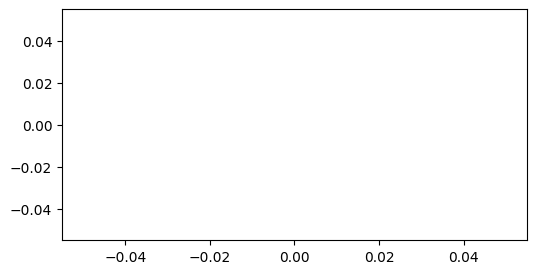

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -52      |
| time/              |          |
|    fps             | 146      |
|    iterations      | 1        |
|    time_elapsed    | 13       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 999        |
|    ep_rew_mean          | -50        |
| time/                   |            |
|    fps                  | 142        |
|    iterations           | 2          |
|    time_elapsed         | 28         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00769101 |
|    clip_fraction        | 0.0304     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.37      |
|    explained_variance   | 0.00248    |
|    learning_rate        | 0.0003     |
|   

In [16]:
log_dir = "/tmp/gym"
os.makedirs(log_dir, exist_ok=True)

env = make_vec_env("MountainCarContinuous-v0", n_envs=1, monitor_dir=log_dir)

plotting_callback = PlottingCallback()

model = PPO("MlpPolicy", env, verbose=1)
model.learn(5000, callback=plotting_callback)

In [17]:
env = make_vec_env("MountainCarContinuous-v0", n_envs=1, monitor_dir=log_dir)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(5000)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -51.1    |
| time/              |          |
|    fps             | 6972     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 999         |
|    ep_rew_mean          | -50         |
| time/                   |             |
|    fps                  | 4366        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006449253 |
|    clip_fraction        | 0.0277      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.00179    |
|    learning

### Exercise: Code your own callback

Save best model based on test environment evaluation

In [10]:
class EvalCallback(BaseCallback):
    """
    Callback for evaluating an agent.
    
    :param eval_env: (gym.Env)
    :param n_eval_episodes: (int)
    :param eval_freq: (int)
    """

    def __init__(self, eval_env, n_eval_episodes=5, eval_freq=20):
        super().__init__()
        self.eval_env = eval_env
        self.n_eval_episodes = n_eval_episodes
        self.eval_freq = eval_freq
        self.best_mean_reward = -np.inf
        self.log_dir = "/tmp/gym/"

    def _on_step(self):
        """
        Called by model every step.
        
        :return: (bool)
        """

        # self.n_calls automatically updated by BaseCallback
        if self.n_calls % self.eval_freq == 0:
            # evaluate policy
            rewards = []

            for _ in range(self.n_eval_episodes):
                total_reward = 0
                done = False
                obs = self.eval_env.reset()

                while not done:
                    action = self.model.predict(obs, deterministic=True)
                    obs, reward, terminated, truncated, _info = self.eval_env.step(action)
                    total_reward += reward
                    done = terminated or truncated
                
                rewards.append(total_reward)

            mean_reward = np.mean(rewards)
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                self.model.save(log_dir + "best_model")
                print(f"New best mean reward: {self.best_mean_reward:.2f}")

        return True

In [11]:
from stable_baselines3.common.env_util import make_vec_env

# Env used for training
env = make_vec_env("CartPole-v1", n_envs=1)
# Env for evaluating the agent
eval_env = make_vec_env("CartPole-v1", n_envs=1)

# === YOUR CODE HERE ===#
# Create the callback object
callback = EvalCallback(eval_env=eval_env, n_eval_episodes=5, eval_freq=20)

# Create the RL model
model = PPO("MlpPolicy", env, verbose=1)

# ====================== #

# Train the RL model
model.learn(int(100000), callback=callback)

Using cpu device


AssertionError: array([0]) (<class 'numpy.ndarray'>) invalid